In [ ]:
!pip install -U openai

  Using cached openai-1.23.2-py3-none-any.whl.metadata (21 kB)
Using cached openai-1.23.2-py3-none-any.whl (311 kB)
  Attempting uninstall: openai
    Found existing installation: openai 0.28.0
    Uninstalling openai-0.28.0:
      Successfully uninstalled openai-0.28.0

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
train_df = pd.read_csv("TaskA_train.csv")
val_df = pd.read_csv("TaskA_dev.csv")
test_df = pd.read_csv("TaskA_test.csv")
train_df.head()

,topic,Premise,Conclusion,Validity,Validity-Confidence,Novelty,Novelty-Confidence
0,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Depression is a well-known psychological probl...,1,confident,1,confident
1,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Children's TV viewing fosters negative emotions,1,very confident,-1,majority
2,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Popularity of TV is harmful to children,1,very confident,1,majority
3,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Violence on TV and in movies encourages psycho...,1,very confident,1,majority
4,TV viewing is harmful to children,The popularity of TV watching is among the rea...,US-India deal does not cap or limit Indian fis...,-1,very confident,-1,very confident


In [ ]:
# prompt:  map the valididty to "valid" if entry is 1 else "not-valid";  map the Novelty to "novel" if entry is 1 else "not-novel"

train_df['Validity'] = train_df['Validity'].apply(lambda x: 'valid' if x == 1 else 'not-valid')
train_df['Novelty'] = train_df['Novelty'].apply(lambda x: 'novel' if x == 1 else 'not-novel')
val_df['Validity'] = val_df['Validity'].apply(lambda x: 'valid' if x == 1 else 'not-valid')
val_df['Novelty'] = val_df['Novelty'].apply(lambda x: 'novel' if x == 1 else 'not-novel')
test_df['Validity'] = test_df['Validity'].apply(lambda x: 'valid' if x == 1 else 'not-valid')
test_df['Novelty'] = test_df['Novelty'].apply(lambda x: 'novel' if x == 1 else 'not-novel')

In [92]:
def convert_to_gpt35_format_v(dataset):
    fine_tuning_data = []
    for _, row in dataset.iterrows():
        json_response = 'Validity: '  + row['Validity']
        prompt = "TOPIC: " + row['topic'] + " \n PREMISE: " + row['Premise'] + " \n CONCLUSION: " + row['Conclusion'] + " \n Validity: "
        fine_tuning_data.append({
            "messages": [
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": json_response}
            ]
        })
    return fine_tuning_data

def convert_to_gpt35_format_n(dataset):
    fine_tuning_data = []
    for _, row in dataset.iterrows():
        json_response = 'Novelty: '  + row['Novelty']
        prompt = "TOPIC: " + row['topic'] + "\n PREMISE: " + row['Premise'] + "\n CONCLUSION: " + row['Conclusion'] + "\n Novelty: "
        fine_tuning_data.append({
            "messages": [
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": json_response}
            ]
        })
    return fine_tuning_data

In [93]:
train_data_v = convert_to_gpt35_format_v(train_df)
val_data_v = convert_to_gpt35_format_v(val_df)
test_data_v = convert_to_gpt35_format_v(test_df)
train_data_n = convert_to_gpt35_format_n(train_df)
val_data_n = convert_to_gpt35_format_n(val_df)
test_data_n = convert_to_gpt35_format_n(test_df)

In [ ]:
import json
def write_to_jsonl(data, file_path):
    with open(file_path, 'w') as file:
        for entry in data:
            json.dump(entry, file)
            file.write('\n')

training_file_name_v = "train_validity.jsonl"
validation_file_name_v = "val_validity.jsonl"
training_file_name_n = "train_novelty.jsonl"
validation_file_name_n = "val_novelty.jsonl"
test_file_name_v = "test_validity.jsonl"
test_file_name_n = "test_novelty.jsonl"

write_to_jsonl(train_data_v, training_file_name_v)
write_to_jsonl(val_data_v, validation_file_name_v)
write_to_jsonl(train_data_n, training_file_name_n)
write_to_jsonl(val_data_n, validation_file_name_n)
write_to_jsonl(test_data_v, test_file_name_v)
write_to_jsonl(test_data_n, test_file_name_n)

In [ ]:
import openai
from openai import OpenAI
from time import sleep

In [79]:
OPENAI_API_KEY = "your key"
cache = {}

model_name = {0:["your model 0","your model 0"],\
              1:["your model 1","your model 1"],\
              2:["your model 2","your model 2"],\
              3:["your model 3","your model 3"],\
              4:[],\
              5:[],\
              6:[],\
              7:["your model 7","your model 7"]}
def run_gpt3(prompt, return_first_line = False, Task = "n",k=0):

    client = OpenAI(
      api_key=OPENAI_API_KEY,
    )

    if Task == "n":
        model = model_name[k][0]
    elif Task == "v" :
        model = model_name[k][1]
    else:
        return "Invalid Task"

    for i in range(0,60,6):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=prompt,
                temperature=0,
                max_tokens=100,
                top_p=1,
                frequency_penalty=0.0,
                presence_penalty=0.0,
            )
            response = response.choices[0].message.content

            break
        except Exception as e:
            print(e)
            sleep(i)

    if return_first_line:
        final_response = response.split('\n')[0]
    else:
        final_response = response
    return final_response

In [90]:
print(run_gpt3(prompt = [{"role":"user", "content": "TOPIC: US offshore oil drilling \n PREMISE: These large ships release significant pollution into the oceans, and carry some risk of hitting the shore, and causing a spill. \n CONCLUSION: Large oil drilling rigs are often anchored offshore \n Novelty: (novel/not-novel) "}], Task = "n", k=7))

novel


In [ ]:
y_true = {'novelty': [], 'validity': []}
y_pred = {'novelty': [], 'validity': []}

In [ ]:
for _, row in test_df.iterrows():
  y_true['validity'].append(1 if row['Validity'] == 'valid' else 0)
  y_true['novelty'].append(1 if row['Novelty'] == 'novel' else 0)


In [69]:
def count_y_pred_v(mydata, y_pred=[],k=0):
  count = 0
  for data in mydata:
    count += 1
    if count % 100 == 0:
      print(count)
    response = run_gpt3(prompt = [data['messages'][0]], Task = "v",k=k)
    if response == 'valid':
      y_pred.append(1)
    elif response == 'Validity: valid':
      y_pred.append(1)
    elif response == 'Validity: not-valid':
      y_pred.append(0)
    elif response == 'not-valid':
      y_pred.append(0)
    elif 'not-valid' in response:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred

In [70]:
def count_y_pred_n(mydata, y_pred=[],k=0):
  count = 0
  for data in mydata:
    count += 1
    if count % 100 == 0:
      print(count)
    response = run_gpt3(prompt = [data['messages'][0]], Task = "n",k=k)
    if response == 'novel':
      y_pred.append(1)
    elif response == 'Novelty: novel':
      y_pred.append(1)
    elif response == 'Novelty: not-novel':
      y_pred.append(0)
    elif response == 'not-novel':
      y_pred.append(0)
    elif 'not-novel' in response:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred

In [ ]:
from sklearn.metrics import classification_report
from typing import Dict
import numpy as np
class SharedTaskConstants:
    """
    Use these constants to interface with the data, not with the id2label used
    inside the Huggingface models!!
    """
    targets = ['validity', 'novelty']
    validity_label_mapping = {
        -1: "not-valid",
        0: "not-valid",  # can be excluded since test set does not contain these
        1: "valid",
    }

    novelty_label_mapping = {
        -1: "not-novel",
        0: "not-novel",  # can be excluded since test set does not contain these
        1: "novel",
    }

    validity_id2label = {v: k for k, v in validity_label_mapping.items()}
    novelty_id2label = {v: k for k, v in novelty_label_mapping.items()}

    local_str_mapping = {
        'novel': 1,
        'not-novel': 0,
        'valid': 1,
        'not-valid': 0
    }

    @staticmethod
    def val_nov_metric(is_validity: np.ndarray, should_validity: np.ndarray, is_novelty: np.ndarray,
                       should_novelty: np.ndarray) -> Dict[str, float]:
        ret = dict()

        ret_base_help = {
            "true_positive_validity": np.sum(np.where(
                np.all(np.stack([is_validity >= .5, should_validity >= .5]), axis=0),
                1, 0)),
            "true_positive_novelty": np.sum(np.where(
                np.all(np.stack([is_novelty >= .5, should_novelty >= .5]), axis=0),
                1, 0)),
            "true_positive_valid_novel": np.sum(np.where(
                np.all(np.stack([is_validity >= .5, is_novelty >= .5,
                                 should_validity >= .5, should_novelty >= .5]), axis=0),
                1, 0)),
            "true_positive_nonvalid_novel": np.sum(np.where(
                np.all(np.stack([is_validity < .5, is_novelty >= .5,
                                 should_validity < .5, should_novelty >= .5]), axis=0),
                1, 0)),
            "true_positive_valid_nonnovel": np.sum(np.where(
                np.all(np.stack([is_validity >= .5, is_novelty < .5,
                                 should_validity >= .5, should_novelty < .5]), axis=0),
                1, 0)),
            "true_positive_nonvalid_nonnovel": np.sum(np.where(
                np.all(np.stack([is_validity < .5, is_novelty < .5,
                                 should_validity < .5, should_novelty < .5]), axis=0),
                1, 0)),
            "classified_positive_validity": np.sum(np.where(is_validity >= .5, 1, 0)),
            "classified_positive_novelty": np.sum(np.where(is_novelty >= .5, 1, 0)),
            "classified_positive_valid_novel": np.sum(np.where(
                np.all(np.stack([is_validity >= .5, is_novelty >= .5]), axis=0),
                1, 0)),
            "classified_positive_nonvalid_novel": np.sum(np.where(
                np.all(np.stack([is_validity < .5, is_novelty >= .5]), axis=0),
                1, 0)),
            "classified_positive_valid_nonnovel": np.sum(np.where(
                np.all(np.stack([is_validity >= .5, is_novelty < .5]), axis=0),
                1, 0)),
            "classified_positive_nonvalid_nonnovel": np.sum(np.where(
                np.all(np.stack([is_validity < .5, is_novelty < .5]), axis=0),
                1, 0)),
            "indeed_positive_validity": np.sum(np.where(should_validity >= .5, 1, 0)),
            "indeed_positive_novelty": np.sum(np.where(should_novelty >= .5, 1, 0)),
            "indeed_positive_valid_novel": np.sum(np.where(
                np.all(np.stack([should_validity >= .5, should_novelty >= .5]), axis=0),
                1, 0)),
            "indeed_positive_nonvalid_novel": np.sum(np.where(
                np.all(np.stack([should_validity < .5, should_novelty >= .5]), axis=0),
                1, 0)),
            "indeed_positive_valid_nonnovel": np.sum(np.where(
                np.all(np.stack([should_validity >= .5, should_novelty < .5]), axis=0),
                1, 0)),
            "indeed_positive_nonvalid_nonnovel": np.sum(np.where(
                np.all(np.stack([should_validity < .5, should_novelty < .5]), axis=0),
                1, 0)),
        }

        ret_help = {
            "precision_validity": ret_base_help["true_positive_validity"] /
                                  max(1, ret_base_help["classified_positive_validity"]),
            "precision_novelty": ret_base_help["true_positive_novelty"] /
                                 max(1, ret_base_help["classified_positive_novelty"]),
            "recall_validity": ret_base_help["true_positive_validity"] /
                               max(1, ret_base_help["indeed_positive_validity"]),
            "recall_novelty": ret_base_help["true_positive_novelty"] /
                              max(1, ret_base_help["indeed_positive_novelty"]),
            "precision_valid_novel": ret_base_help["true_positive_valid_novel"] /
                                     max(1, ret_base_help["classified_positive_valid_novel"]),
            "precision_valid_nonnovel": ret_base_help["true_positive_valid_nonnovel"] /
                                        max(1, ret_base_help["classified_positive_valid_nonnovel"]),
            "precision_nonvalid_novel": ret_base_help["true_positive_nonvalid_novel"] /
                                        max(1, ret_base_help["classified_positive_nonvalid_novel"]),
            "precision_nonvalid_nonnovel": ret_base_help["true_positive_nonvalid_nonnovel"] /
                                           max(1, ret_base_help["classified_positive_nonvalid_nonnovel"]),
            "recall_valid_novel": ret_base_help["true_positive_valid_novel"] /
                                  max(1, ret_base_help["indeed_positive_valid_novel"]),
            "recall_valid_nonnovel": ret_base_help["true_positive_valid_nonnovel"] /
                                     max(1, ret_base_help["indeed_positive_valid_nonnovel"]),
            "recall_nonvalid_novel": ret_base_help["true_positive_nonvalid_novel"] /
                                     max(1, ret_base_help["indeed_positive_nonvalid_novel"]),
            "recall_nonvalid_nonnovel": ret_base_help["true_positive_nonvalid_nonnovel"] /
                                        max(1, ret_base_help["indeed_positive_nonvalid_nonnovel"])
        }

        ret.update({
            "f1_validity": 2 * ret_help["precision_validity"] * ret_help["recall_validity"] / max(1e-4, ret_help[
                "precision_validity"] + ret_help["recall_validity"]),
            "f1_novelty": 2 * ret_help["precision_novelty"] * ret_help["recall_novelty"] / max(1e-4, ret_help[
                "precision_novelty"] + ret_help["recall_novelty"]),
            "f1_valid_novel": 2 * ret_help["precision_valid_novel"] * ret_help["recall_valid_novel"] / max(1e-4,
                                                                                                           ret_help[
                                                                                                               "precision_valid_novel"] +
                                                                                                           ret_help[
                                                                                                               "recall_valid_novel"]),
            "f1_valid_nonnovel": 2 * ret_help["precision_valid_nonnovel"] * ret_help["recall_valid_nonnovel"] / max(
                1e-4, ret_help["precision_valid_nonnovel"] + ret_help["recall_valid_nonnovel"]),
            "f1_nonvalid_novel": 2 * ret_help["precision_nonvalid_novel"] * ret_help["recall_nonvalid_novel"] / max(
                1e-4, ret_help["precision_nonvalid_novel"] + ret_help["recall_nonvalid_novel"]),
            "f1_nonvalid_nonnovel": 2 * ret_help["precision_nonvalid_nonnovel"] * ret_help[
                "recall_nonvalid_nonnovel"] / max(1e-4, ret_help["precision_nonvalid_nonnovel"] + ret_help[
                "recall_nonvalid_nonnovel"])
        })

        ret.update({
            "f1_macro": (ret["f1_valid_novel"] + ret["f1_valid_nonnovel"] + ret["f1_nonvalid_novel"] + ret[
                "f1_nonvalid_nonnovel"]) / 4
        })

        return ret

In [ ]:
def print_results(baseline_name: str, y_true: dict, y_pred: dict):
    print(f"==== {baseline_name} ====")
    print("Validity")
    results_validity = classification_report(
        y_true['validity'],
        y_pred['validity'],
        target_names=['not-valid', 'valid'],
        labels=[0, 1],
        zero_division=0
    )
    print(results_validity)

    print("Novelty")
    results_novelty = classification_report(
        y_true['novelty'],
        y_pred['novelty'],
        target_names=['not-novel', 'novel'],
        labels=[0, 1],
        zero_division=0
    )
    print(results_novelty)

    print("Combined (organization eval)")
    res = SharedTaskConstants.val_nov_metric(
        np.array(y_pred['validity']),
        np.array(y_true['validity']),
        np.array(y_pred['novelty']),
        np.array(y_true['novelty']),
    )
    print(res['f1_macro'].round(4))


In [23]:
y_train_true = {'novelty': [], 'validity': []}
for _, row in train_df.iterrows():
  y_train_true['validity'].append(1 if row['Validity'] == 'valid' else 0)
  y_train_true['novelty'].append(1 if row['Novelty'] == 'novel' else 0)

In [21]:
y_train_pred0 = {'novelty': [], 'validity': []}
y_train_pred0['novelty'] = count_y_pred_n(train_data_n, [],k=0)
y_train_pred0['validity'] = count_y_pred_v(train_data_v, [],k=0)

100
200
300
400
500
600
700
100
200
300
400
500
600
700


In [24]:
print_results("1",y_train_true,y_train_pred0)

==== 1 ====
Validity
              precision    recall  f1-score   support

   not-valid       0.93      0.90      0.92       349
       valid       0.92      0.95      0.93       401

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750

Novelty
              precision    recall  f1-score   support

   not-novel       0.84      1.00      0.91       627
       novel       0.00      0.00      0.00       123

    accuracy                           0.84       750
   macro avg       0.42      0.50      0.46       750
weighted avg       0.70      0.84      0.76       750

Combined (organization eval)
0.422


In [25]:
y_pred['novelty'] = count_y_pred_n(test_data_n, [], k=0)
y_pred['validity'] = count_y_pred_v(test_data_v, [], k=0)

100
200
300
400
500
100
200
300
CONCLUSION: Risk of civil war/conflict in Iraq: 
 Validity: valid
400
500


In [94]:
test = {'novelty': [], 'validity': []}
test['novelty'] = count_y_pred_n(test_data_n, [], k=7)
test['validity'] = count_y_pred_v(test_data_v, [], k=7)

100
200
300
400
500
100
200
300
400
500


In [95]:
print_results("0",y_true,test)

==== 0 ====
Validity
              precision    recall  f1-score   support

   not-valid       0.00      0.00      0.00       206
       valid       0.60      1.00      0.75       314

    accuracy                           0.60       520
   macro avg       0.30      0.50      0.38       520
weighted avg       0.36      0.60      0.45       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.50      0.05      0.09       294
       novel       0.43      0.94      0.59       226

    accuracy                           0.43       520
   macro avg       0.47      0.49      0.34       520
weighted avg       0.47      0.43      0.31       520

Combined (organization eval)
0.1107


In [26]:
print_results("1",y_true,y_pred)

==== 1 ====
Validity
              precision    recall  f1-score   support

   not-valid       0.84      0.67      0.75       206
       valid       0.81      0.91      0.86       314

    accuracy                           0.82       520
   macro avg       0.82      0.79      0.80       520
weighted avg       0.82      0.82      0.81       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.57      1.00      0.72       294
       novel       0.00      0.00      0.00       226

    accuracy                           0.57       520
   macro avg       0.28      0.50      0.36       520
weighted avg       0.32      0.57      0.41       520

Combined (organization eval)
0.2959


# K = 1

In [27]:
w_v = [1/len(train_df) for _ in range(len(train_df))]
w_n = [1/len(train_df) for _ in range(len(train_df))]
eps_v_1 = 1- 0.92
eps_n_1 = 1- 0.84
alpha_v_1 = np.log((1 -eps_v_1) / eps_v_1)
alpha_n_1 = np.log((1 -eps_n_1) / eps_n_1)


In [28]:
w_v_1 = [0 for i in range(len(w_v))]
w_n_1 = [0 for i in range(len(w_v))]

for i in range(len(y_train_true['validity'])):
    if y_train_true['validity'][i] != y_train_pred0['validity'][i]:
        w_v_1[i] = w_v[i] * np.exp(alpha_v_1)
    else:
        w_v_1[i] = w_v[i] * np.exp(-alpha_v_1)

for i in range(len(y_train_true['novelty'])):
    if y_train_true['novelty'][i] != y_train_pred0['novelty'][i]:
        w_n_1[i] = w_n[i] * np.exp(-alpha_n_1)
    else:
        w_n_1[i] = w_n[i] *np.exp(alpha_n_1)

w_v_1 = [x / sum(w_v_1) for x in w_v_1]
w_n_1 = [x / sum(w_n_1) for x in w_n_1]

In [29]:
label_v = {1: "valid", 0: "invalid"}
label_n = {1: "novel", 0: "non-novel"}

In [30]:
import copy
train_data_v_new = copy.deepcopy(train_data_v)
train_data_n_new = copy.deepcopy(train_data_n)

In [31]:
for i in range(len(train_data_v)):
  train_data_v_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_v[y_train_pred0["validity"][i]] + '. BUT its error rate is 8%, so there is 8% chance that this result is wrong. Based on this, predict the validity of the CONCLUSION. \n '  + train_data_v[i]['messages'][0]['content']

for i in range(len(train_data_n)):
  train_data_n_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_n[y_train_pred0["novelty"][i]] + '. BUT its error rate is 16%, so there is 16% chance that this result is wrong. Based on this, predict the novelty of the CONCLUSION. \n '  + train_data_n[i]['messages'][0]['content']

In [32]:
from math import ceil
train_data_v_1 = []
train_data_n_1 = []
for i in range(len(train_data_v)):
    if w_v_1[i] > w_v[i]:
      train_data_v_1.extend([train_data_v_new[i]] * ceil(w_v_1[i]/w_v[i]))
    else:
      train_data_v_1.append(train_data_v_new[i])

    if w_n_1[i] > w_n[i]:
      train_data_n_1.extend([train_data_n_new[i]] * ceil(w_n_1[i]/w_n[i]))
    else:
      train_data_n_1.append(train_data_n_new[i])

In [33]:
training_file_name_v = 'train_data_v_1.jsonl'
training_file_name_n = 'train_data_n_1.jsonl'
write_to_jsonl(train_data_v_1, training_file_name_v)
write_to_jsonl(train_data_n_1, training_file_name_n)

In [36]:
y_train_pred_1 = {'novelty': [], 'validity': []}

y_train_pred_1['validity'] = count_y_pred_v(train_data_v_new,[],k=1)
y_train_pred_1['novelty'] = count_y_pred_n(train_data_n_new,[],k=1)

100
200
300
400
500
600
700
100
200
300
400
500
600
700


In [37]:
print_results("1",y_train_true,y_train_pred_1)

==== 1 ====
Validity
              precision    recall  f1-score   support

   not-valid       1.00      1.00      1.00       349
       valid       1.00      1.00      1.00       401

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750

Novelty
              precision    recall  f1-score   support

   not-novel       0.99      1.00      0.99       627
       novel       1.00      0.94      0.97       123

    accuracy                           0.99       750
   macro avg       0.99      0.97      0.98       750
weighted avg       0.99      0.99      0.99       750

Combined (organization eval)
0.9696


In [38]:
test_data_v_new = copy.deepcopy(test_data_v)
test_data_n_new = copy.deepcopy(test_data_n)
for i in range(len(test_data_v)):
  test_data_v_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_v[y_pred["validity"][i]] + '. BUT its error rate is 8%, so there is 8% chance that this result is wrong. Based on this, predict the validity of the CONCLUSION. \n '  + test_data_v[i]['messages'][0]['content']

for i in range(len(test_data_n)):
  test_data_n_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_n[y_pred["novelty"][i]] + '. BUT its error rate is 16%, so there is 16% chance that this result is wrong. Based on this, predict the novelty of the CONCLUSION. \n '  + test_data_n[i]['messages'][0]['content']

In [39]:
y_pred_1 = {'novelty': [], 'validity': []}
y_pred_1['novelty'] = count_y_pred_n(test_data_n_new, [],k=1)
y_pred_1['validity'] = count_y_pred_v(test_data_v_new, [],k=1)

100
200
300
400
500
100
200
300
400
500


In [40]:
print_results("1",y_true,y_pred_1)

==== 1 ====
Validity
              precision    recall  f1-score   support

   not-valid       0.88      0.64      0.74       206
       valid       0.80      0.94      0.86       314

    accuracy                           0.82       520
   macro avg       0.84      0.79      0.80       520
weighted avg       0.83      0.82      0.81       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.59      0.92      0.72       294
       novel       0.62      0.17      0.26       226

    accuracy                           0.59       520
   macro avg       0.61      0.54      0.49       520
weighted avg       0.60      0.59      0.52       520

Combined (organization eval)
0.3843


# K=2

In [42]:
eps_v_2 = 1- 0.99
eps_n_2 = 1- 0.99
alpha_v_2 = np.log((1 -eps_v_2) / eps_v_2)
alpha_n_2 = np.log((1 -eps_n_2) / eps_n_2)

w_v_2 = [0 for i in range(len(w_v))]
w_n_2 = [0 for i in range(len(w_v))]

for i in range(len(y_train_true['validity'])):
    if y_train_true['validity'][i] != y_train_pred_1['validity'][i]:
        w_v_2[i] = w_v_1[i] * np.exp(alpha_v_2)
    else:
        w_v_2[i] = w_v_1[i] * np.exp(-alpha_v_2)

for i in range(len(y_train_true['novelty'])):
    if y_train_true['novelty'][i] != y_train_pred_1['novelty'][i]:
        w_n_2[i] = w_n_1[i] * np.exp(alpha_n_2)
    else:
        w_n_2[i] = w_n_1[i] * np.exp(-alpha_n_2)

w_v_2 = [x / sum(w_v_2) for x in w_v_2]
w_n_2 = [x / sum(w_n_2) for x in w_n_2]


In [55]:
train_data_v_new = copy.deepcopy(train_data_v)
train_data_n_new = copy.deepcopy(train_data_n)

for i in range(len(train_data_v)):
  train_data_v_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_v[y_train_pred_1["validity"][i]] + '. BUT its error rate is 1%, so there is 1% chance that this result is wrong. Based on this, predict the validity of the CONCLUSION. \n '  + train_data_v[i]['messages'][0]['content']

for i in range(len(train_data_n)):
  train_data_n_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_n[y_train_pred_1["novelty"][i]] + '. BUT its error rate is 1%, so there is 1% chance that this result is wrong. Based on this, predict the novelty of the CONCLUSION. \n '  + train_data_n[i]['messages'][0]['content']

train_data_v_2 = []
train_data_n_2 = []
for i in range(len(train_data_v)):
    if w_v_2[i] > w_v_1[i]:
      train_data_v_2.extend([train_data_v_new[i]] * ceil(w_v_2[i]/w_v_1[i]))
    else:
      train_data_v_2.append(train_data_v_new[i])

    if w_n_2[i] > w_n_1[i]:
      train_data_n_2.extend([train_data_n_new[i]] * min(ceil(w_n_2[i]/w_n_1[i]),50))
    else:
      train_data_n_2.append(train_data_n_new[i])

training_file_name_v = 't_v_2.jsonl'
training_file_name_n = 't_n_2.jsonl'
write_to_jsonl(train_data_v_2, training_file_name_v)
write_to_jsonl(train_data_n_2, training_file_name_n)


In [59]:
y_train_pred_2 = {'novelty': [], 'validity': []}

y_train_pred_2['validity'] = count_y_pred_v(train_data_v_new,[],k=2)
y_train_pred_2['novelty'] = count_y_pred_n(train_data_n_new,[],k=2)

100
200
300
400
500
600
700
100
200
300
400
500
600
700


In [60]:
print_results("2",y_train_true,y_train_pred_2)

==== 2 ====
Validity
              precision    recall  f1-score   support

   not-valid       1.00      1.00      1.00       349
       valid       1.00      1.00      1.00       401

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750

Novelty
              precision    recall  f1-score   support

   not-novel       1.00      1.00      1.00       627
       novel       0.99      0.99      0.99       123

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750

Combined (organization eval)
0.9968


In [80]:
test_data_v_new = copy.deepcopy(test_data_v)
test_data_n_new = copy.deepcopy(test_data_n)
for i in range(len(test_data_v)):
  test_data_v_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_v[y_pred_1["validity"][i]] + '. BUT its error rate is 1%, so there is 1% chance that this result is wrong. Based on this, predict the validity of the CONCLUSION. \n '  + test_data_v[i]['messages'][0]['content']

for i in range(len(test_data_n)):
  test_data_n_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_n[y_pred_1["novelty"][i]] + '. BUT its error rate is 1%, so there is 1% chance that this result is wrong. Based on this, predict the novelty of the CONCLUSION. \n '  + test_data_n[i]['messages'][0]['content']

In [ ]:
test_data_v_new

In [81]:
y_pred_2 = {'novelty': [], 'validity': []}
y_pred_2['novelty'] = count_y_pred_n(test_data_n_new, [],k=2)
y_pred_2['validity'] = count_y_pred_v(test_data_v_new, [],k=2)

100
200
300
400
500
100
200
300
400
500


In [82]:
print_results("2",y_true,y_pred_2)

==== 2 ====
Validity
              precision    recall  f1-score   support

   not-valid       0.78      0.68      0.73       206
       valid       0.81      0.88      0.84       314

    accuracy                           0.80       520
   macro avg       0.79      0.78      0.78       520
weighted avg       0.80      0.80      0.80       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.59      0.95      0.73       294
       novel       0.68      0.15      0.25       226

    accuracy                           0.60       520
   macro avg       0.64      0.55      0.49       520
weighted avg       0.63      0.60      0.52       520

Combined (organization eval)
0.3798


# K=3

In [72]:
eps_v_3 = 1- 0.99
eps_n_3 = 1- 0.99
alpha_v_3 = np.log((1 -eps_v_3) / eps_v_3)
alpha_n_3 = np.log((1 -eps_n_3) / eps_n_3)

w_v_3 = [0 for i in range(len(w_v))]
w_n_3 = [0 for i in range(len(w_v))]

for i in range(len(y_train_true['validity'])):
    if y_train_true['validity'][i] != y_train_pred_2['validity'][i]:
        w_v_3[i] = w_v_2[i] * np.exp(alpha_v_3)
    else:
        w_v_3[i] = w_v_2[i] * np.exp(-alpha_v_3)

for i in range(len(y_train_true['novelty'])):
    if y_train_true['novelty'][i] != y_train_pred_2['novelty'][i]:
        w_n_3[i] = w_n_2[i] * np.exp(alpha_n_3)
    else:
        w_n_3[i] = w_n_2[i] * np.exp(-alpha_n_3)

w_v_3 = [x / sum(w_v_3) for x in w_v_3]
w_n_3 = [x / sum(w_n_3) for x in w_n_3]

In [73]:
train_data_v_new = copy.deepcopy(train_data_v)
train_data_n_new = copy.deepcopy(train_data_n)

for i in range(len(train_data_v)):
  train_data_v_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_v[y_train_pred_2["validity"][i]] + '. BUT its error rate is 1%, so there is 1% chance that this result is wrong. Based on this, predict the validity of the CONCLUSION. \n '  + train_data_v[i]['messages'][0]['content']

for i in range(len(train_data_n)):
  train_data_n_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_n[y_train_pred_2["novelty"][i]] + '. BUT its error rate is 1%, so there is 1% chance that this result is wrong. Based on this, predict the novelty of the CONCLUSION. \n '  + train_data_n[i]['messages'][0]['content']

train_data_v_3 = []
train_data_n_3 = []
for i in range(len(train_data_v)):
    if w_v_3[i] > w_v_2[i]:
      train_data_v_3.extend([train_data_v_new[i]] * ceil(w_v_3[i]/w_v_2[i]))
    else:
      train_data_v_3.append(train_data_v_new[i])

    if w_n_3[i] > w_n_2[i]:
      train_data_n_3.extend([train_data_n_new[i]] * min(ceil(w_n_3[i]/w_n_2[i]),50))
    else:
      train_data_n_3.append(train_data_n_new[i])

training_file_name_v = 't_v_3.jsonl'
training_file_name_n = 't_n_3.jsonl'
write_to_jsonl(train_data_v_3, training_file_name_v)
write_to_jsonl(train_data_n_3, training_file_name_n)

In [83]:
test_data_v_new = copy.deepcopy(test_data_v)
test_data_n_new = copy.deepcopy(test_data_n)
for i in range(len(test_data_v)):
  test_data_v_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_v[y_pred_2["validity"][i]] + '. BUT its error rate is 8%, so there is 1% chance that this result is wrong. Based on this, predict the validity of the CONCLUSION. \n '  + test_data_v[i]['messages'][0]['content']

for i in range(len(test_data_n)):
  test_data_n_new[i]['messages'][0]['content'] = 'Given the TOPIC, PREMISE, CONCLUSION, it is known that the prediction result of the previous model is '+ label_n[y_pred_2["novelty"][i]] + '. BUT its error rate is 16%, so there is 1% chance that this result is wrong. Based on this, predict the novelty of the CONCLUSION. \n '  + test_data_n[i]['messages'][0]['content']

In [84]:
y_pred_3 = {'novelty': [], 'validity': []}
y_pred_3['novelty'] = count_y_pred_n(test_data_n_new, [],k=3)
y_pred_3['validity'] = count_y_pred_v(test_data_v_new, [],k=3)

100
200
300
400
500
100
200
300
400
500


In [85]:
print_results("3",y_true,y_pred_3)

==== 3 ====
Validity
              precision    recall  f1-score   support

   not-valid       0.78      0.69      0.73       206
       valid       0.81      0.87      0.84       314

    accuracy                           0.80       520
   macro avg       0.80      0.78      0.79       520
weighted avg       0.80      0.80      0.80       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.59      0.93      0.72       294
       novel       0.64      0.17      0.27       226

    accuracy                           0.60       520
   macro avg       0.62      0.55      0.49       520
weighted avg       0.61      0.60      0.52       520

Combined (organization eval)
0.372


[False]

# ALL

In [99]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

In [135]:
train = pd.read_csv("TaskA_train_neural_kg.csv", index_col=False)
test = pd.read_csv("TaskA_test_neural_kg.csv", index_col=False)

X_train = train.loc[:,["SBERT_premise", "SBERT_conclusion"]]
y_train = train.loc[:,["Validity",'Novelty']]
y_train = y_train.replace(-1, 0)

X_test = test.loc[:,["SBERT_premise", "SBERT_conclusion"]]
y_test = test.loc[:,["Validity",'Novelty']]
y_test = y_test.replace(-1, 0)

In [136]:
def str_to_list(text):
    '''
    Return tensor string into list
    '''
    # clean string
    clean_str = text.replace('tensor(', '').replace(')', '').strip()
    # convert to list
    tensor = eval(clean_str, {"torch": torch, "__builtins__": {}})
    return tensor

def process_covariate_data(df):
    '''
    Expanding all tensors in a single cell
    Make confidence into ordinal variables
    '''
    # convert str to tensor (list)
    SBERT_premise = df.SBERT_premise.apply(lambda x: str_to_list(x))
    SBERT_conclusion = df.SBERT_conclusion.apply(lambda x: str_to_list(x))

    # expand the list into individual entries
    df_expand1 = SBERT_premise.apply(pd.Series)
    df_expand2 = SBERT_conclusion.apply(pd.Series)

    # assign a meaningful name
    df_expand1.columns = ['pre_emb{}'.format(i+1) for i in range(df_expand1.shape[1])]
    df_expand2.columns = ['con_emb{}'.format(i+1) for i in range(df_expand2.shape[1])]

    # put everything together
    df_final = pd.concat([df.drop(['SBERT_premise', "SBERT_conclusion"], axis=1), df_expand1, df_expand2], axis=1)
    return df_final

In [137]:
X_train = process_covariate_data(X_train)
X_test = process_covariate_data(X_test)

/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_63404/2054835346.py:21: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df_expand1 = SBERT_premise.apply(pd.Series)
/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_63404/2054835346.py:22: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df_expand2 = SBERT_conclusion.apply(pd.Series)
/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_63404/2054835346.py:21: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df_expand1 = SBERT_premise.apply(pd.Series)
/var/folders/2v/664l7ccj4vn7kztqkgv6y7mh0000gn/T/ipykernel_63404/2054835346.py:22: FutureWarning: Returning a DataFrame from Series.apply when the s

In [138]:
clf_valid = MLPClassifier(solver='adam', hidden_layer_sizes=(500, 100), alpha=0.1, random_state=259, max_iter=5000)
clf_valid.fit(X_train, y_train.Validity)

clf_novel = MLPClassifier(solver='adam', hidden_layer_sizes=(500, 100), alpha=0.1, random_state=259, max_iter=5000)
clf_novel.fit(X_train, y_train.Novelty)

pred = {}
pred["validity"] = clf_valid.predict(np.array(X_test))
pred["novelty"] = clf_novel.predict(np.array(X_test))
true_y = {"validity": list(y_test.Validity), "novelty": list(y_test.Novelty)}
print_results("MLP",true_y, pred)

==== MLP ====
Validity
              precision    recall  f1-score   support

   not-valid       0.39      0.67      0.50       206
       valid       0.60      0.32      0.42       314

    accuracy                           0.46       520
   macro avg       0.50      0.50      0.46       520
weighted avg       0.52      0.46      0.45       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.57      0.96      0.71       294
       novel       0.46      0.05      0.09       226

    accuracy                           0.56       520
   macro avg       0.51      0.50      0.40       520
weighted avg       0.52      0.56      0.44       520

Combined (organization eval)
0.1913


/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [139]:
X_test_prob = {}
X_test_prob["validity"] = clf_valid.predict_proba(np.array(X_test))[:, 1]
X_test_prob["novelty"] = clf_novel.predict_proba(np.array(X_test))[:, 1]

X_train_prob = {}
X_train_prob["validity"] = clf_valid.predict_proba(np.array(X_train))[:, 1]
X_train_prob["novelty"] = clf_novel.predict_proba(np.array(X_train))[:, 1]

/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [141]:
X_train = train.loc[:,["SBERT_cosine_sim",'Irrelevancy', 'AveDistance']]
y_train = train.loc[:,["Validity",'Novelty']]
y_train = y_train.replace(-1, 0)

X_test = test.loc[:,["SBERT_cosine_sim",'Irrelevancy', 'AveDistance']]
y_test = test.loc[:,["Validity",'Novelty']]
y_test = y_test.replace(-1, 0)

X_train["validity_prob"] = X_train_prob["validity"]
X_train["novelty_prob"] = X_train_prob["novelty"]

X_test["validity_prob"] = X_test_prob["validity"]
X_test["novelty_prob"] = X_test_prob["novelty"]

[1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [165]:
X_train["gpt_n"] =  y_train_pred_2["novelty"]
X_train["gpt_v"] =  y_train_pred_2["validity"]
X_test["gpt_n"] =  y_pred_2["novelty"]
X_test["gpt_v"] =  y_pred_2["validity"]

In [168]:
X_train

,SBERT_cosine_sim,Irrelevancy,AveDistance,validity_prob,novelty_prob,gpt_n,gpt_v
0,0.691556,1.0,3.835000,0.999694,0.968022,1,1
1,0.653264,1.0,3.897143,0.999862,0.008187,0,1
2,0.566383,2.0,3.946667,0.999907,0.987816,1,1
3,0.709627,0.0,3.840000,0.999555,0.987379,1,1
4,-0.023910,4.0,3.955000,0.008250,0.000071,0,0
...,...,...,...,...,...,...,...
745,0.003667,3.0,3.833333,0.014089,0.000260,0,0
746,0.156513,4.0,3.811111,0.026048,0.000048,0,0
747,0.222510,2.0,3.666667,0.999860,0.982451,1,1
748,0.484502,2.0,3.714286,0.997145,0.998245,1,1


In [173]:
C1 = ["SBERT_cosine_sim",'Irrelevancy', 'AveDistance',"gpt_v"]
C2 = ["SBERT_cosine_sim",'Irrelevancy', 'AveDistance',"gpt_n"]
clf_valid = MLPClassifier(solver='adam',activation="relu", hidden_layer_sizes=(5,5), alpha=0.0001, learning_rate_init=0.001, random_state=259, max_iter=10000)
clf_valid.fit(X_train.loc[:,C1], y_train.Validity)

clf_novel = MLPClassifier(solver='adam',activation="relu", hidden_layer_sizes=(5,5), alpha=0.0001, learning_rate_init=0.001, random_state=259, max_iter=10000)
clf_novel.fit(X_train.loc[:,C2], y_train.Novelty)

pred = {}
pred["validity"] = clf_valid.predict(np.array(X_test.loc[:,C1]))
pred["novelty"] = clf_novel.predict(np.array(X_test.loc[:,C1]))
true_y = {"validity": list(y_test.Validity), "novelty": list(y_test.Novelty)}

print_results("MLP", true_y,pred)

==== MLP ====
Validity
              precision    recall  f1-score   support

   not-valid       0.78      0.68      0.73       206
       valid       0.81      0.88      0.84       314

    accuracy                           0.80       520
   macro avg       0.79      0.78      0.78       520
weighted avg       0.80      0.80      0.80       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.50      0.31      0.38       294
       novel       0.40      0.61      0.48       226

    accuracy                           0.44       520
   macro avg       0.45      0.46      0.43       520
weighted avg       0.46      0.44      0.43       520

Combined (organization eval)
0.2436


/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [160]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

C1 = ["SBERT_cosine_sim", 'Irrelevancy', 'AveDistance']#, "validity_prob"]
C2 = ["SBERT_cosine_sim", 'Irrelevancy', 'AveDistance']#, "novelty_prob"]

# Define the parameter grid
param_grid = {
    'solver': ['liblinear', 'saga'],  # Solvers suitable for small datasets and L1 penalty
    'penalty': ['l1', 'l2'],          # L1 for Lasso regression, L2 for Ridge regression
    'C': [0.01, 0.1, 1, 10, 100]      # Inverse of regularization strength
}

# Initialize a GridSearchCV object for validity prediction
grid_valid = GridSearchCV(LogisticRegression(random_state=259), param_grid, cv=5, scoring='accuracy')
grid_valid.fit(X_train.loc[:,C1], y_train.Validity)

# Initialize a GridSearchCV object for novelty prediction
grid_novel = GridSearchCV(LogisticRegression(random_state=259), param_grid, cv=5, scoring='accuracy')
grid_novel.fit(X_train.loc[:,C2], y_train.Novelty)

# Get the best model
best_clf_valid = grid_valid.best_estimator_
best_clf_novel = grid_novel.best_estimator_

# Make predictions using the best model
pred = {
    "validity": best_clf_valid.predict(X_test.loc[:,C1].values),
    "novelty": best_clf_novel.predict(X_test.loc[:,C2].values)
}

# True labels
true_y = {
    "validity": list(y_test.Validity),
    "novelty": list(y_test.Novelty)
}

# Print results (assuming print_results function is defined elsewhere)
print_results("Logistic Regression with Grid Search", true_y, pred)





/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

==== Logistic Regression with Grid Search ====
Validity
              precision    recall  f1-score   support

   not-valid       0.61      0.27      0.38       206
       valid       0.65      0.89      0.75       314

    accuracy                           0.64       520
   macro avg       0.63      0.58      0.56       520
weighted avg       0.63      0.64      0.60       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.57      1.00      0.72       294
       novel       0.00      0.00      0.00       226

    accuracy                           0.57       520
   macro avg       0.28      0.50      0.36       520
weighted avg       0.32      0.57      0.41       520

Combined (organization eval)
0.2198


/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the co

In [176]:
gpt_instruct = {'novelty': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1], 'validity': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}
new_gpt = {}
new_gpt["novelty"] = gpt_instruct['novelty']
new_gpt["validity"] = y_pred_1["validity"]

print_results("best",y_true,new_gpt)


==== best ====
Validity
              precision    recall  f1-score   support

   not-valid       0.88      0.64      0.74       206
       valid       0.80      0.94      0.86       314

    accuracy                           0.82       520
   macro avg       0.84      0.79      0.80       520
weighted avg       0.83      0.82      0.81       520

Novelty
              precision    recall  f1-score   support

   not-novel       0.75      0.43      0.55       294
       novel       0.52      0.81      0.64       226

    accuracy                           0.60       520
   macro avg       0.64      0.62      0.59       520
weighted avg       0.65      0.60      0.59       520

Combined (organization eval)
0.4784


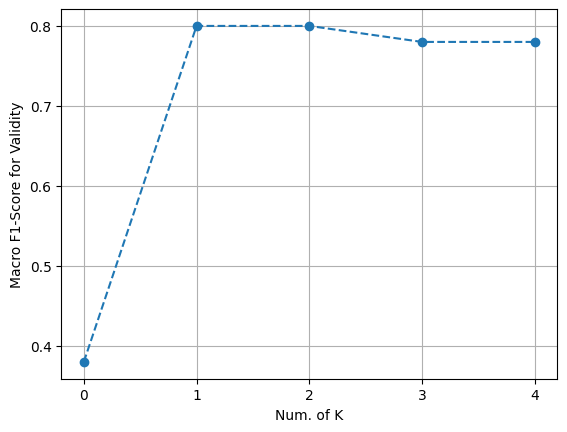

In [190]:
valid_line = [0.38, 0.8,0.8,0.78,0.78]
novel_line = [0.34,0.36,0.49,0.49,0.49]
overall = [0.2390,0.2959,0.3843,0.3836,0.3798]
k = [0,1,2,3,4]

import matplotlib.pyplot as plt
plt.plot(k,valid_line, linestyle='--', marker='o')
plt.xlabel('Num. of K')
plt.ylabel('Macro F1-Score for Validity')
plt.xticks(range(0,5))
plt.grid(True)
plt.show()

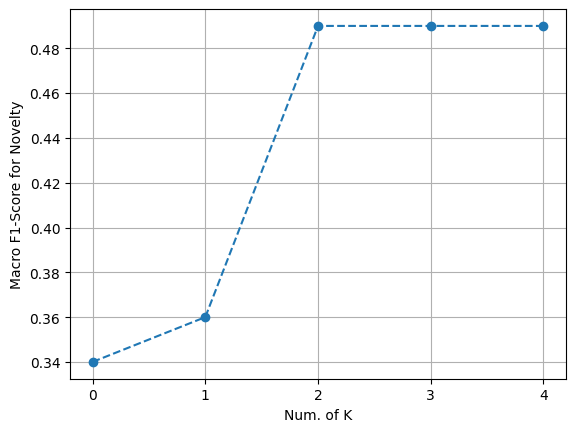

In [189]:
plt.plot(k,novel_line, linestyle='--', marker='o')
plt.xlabel('Num. of K')
plt.ylabel('Macro F1-Score for Novelty')
plt.xticks(range(0,5))
plt.grid(True)
plt.show()

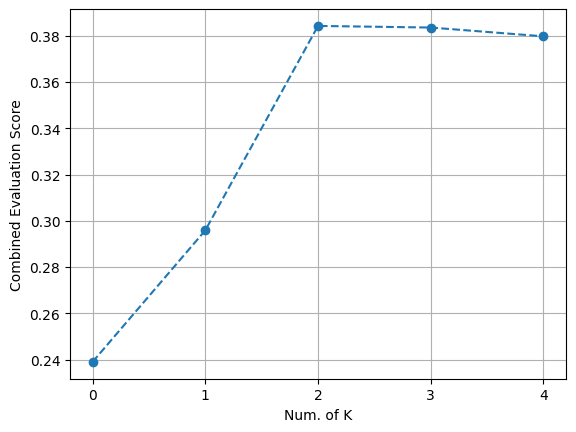

In [188]:
plt.plot(k,overall, linestyle='--', marker='o')
plt.xlabel('Num. of K')
plt.ylabel('Combined Evaluation Score')
plt.xticks(range(0,5))
plt.grid(True)
plt.show()